In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.9 MB/s eta 0:00:00


Mounted at /content/gdrive/

Summary statistics:
         order_id_new  order_try_id_new        calc_created  metered_price  \
count    4943.000000       4943.000000                4943    4923.000000   
unique           NaN               NaN                4165            NaN   
top              NaN               NaN  2020-03-07 1:01:14            NaN   
freq             NaN               NaN                   6            NaN   
mean     2061.074449       2061.074044                 NaN    7998.471296   
std      1199.298429       1199.299081                 NaN   15815.850352   
min         0.000000          0.000000                 NaN       2.000000   
25%      1020.500000       1020.500000                 NaN       5.380000   
50%      2065.000000       2065.000000                 NaN      13.350000   
75%      3090.500000       3090.500000                 NaN   10991.670000   
max      4165.000000       4165.000000                 NaN  194483.520000   

        upfront_price    

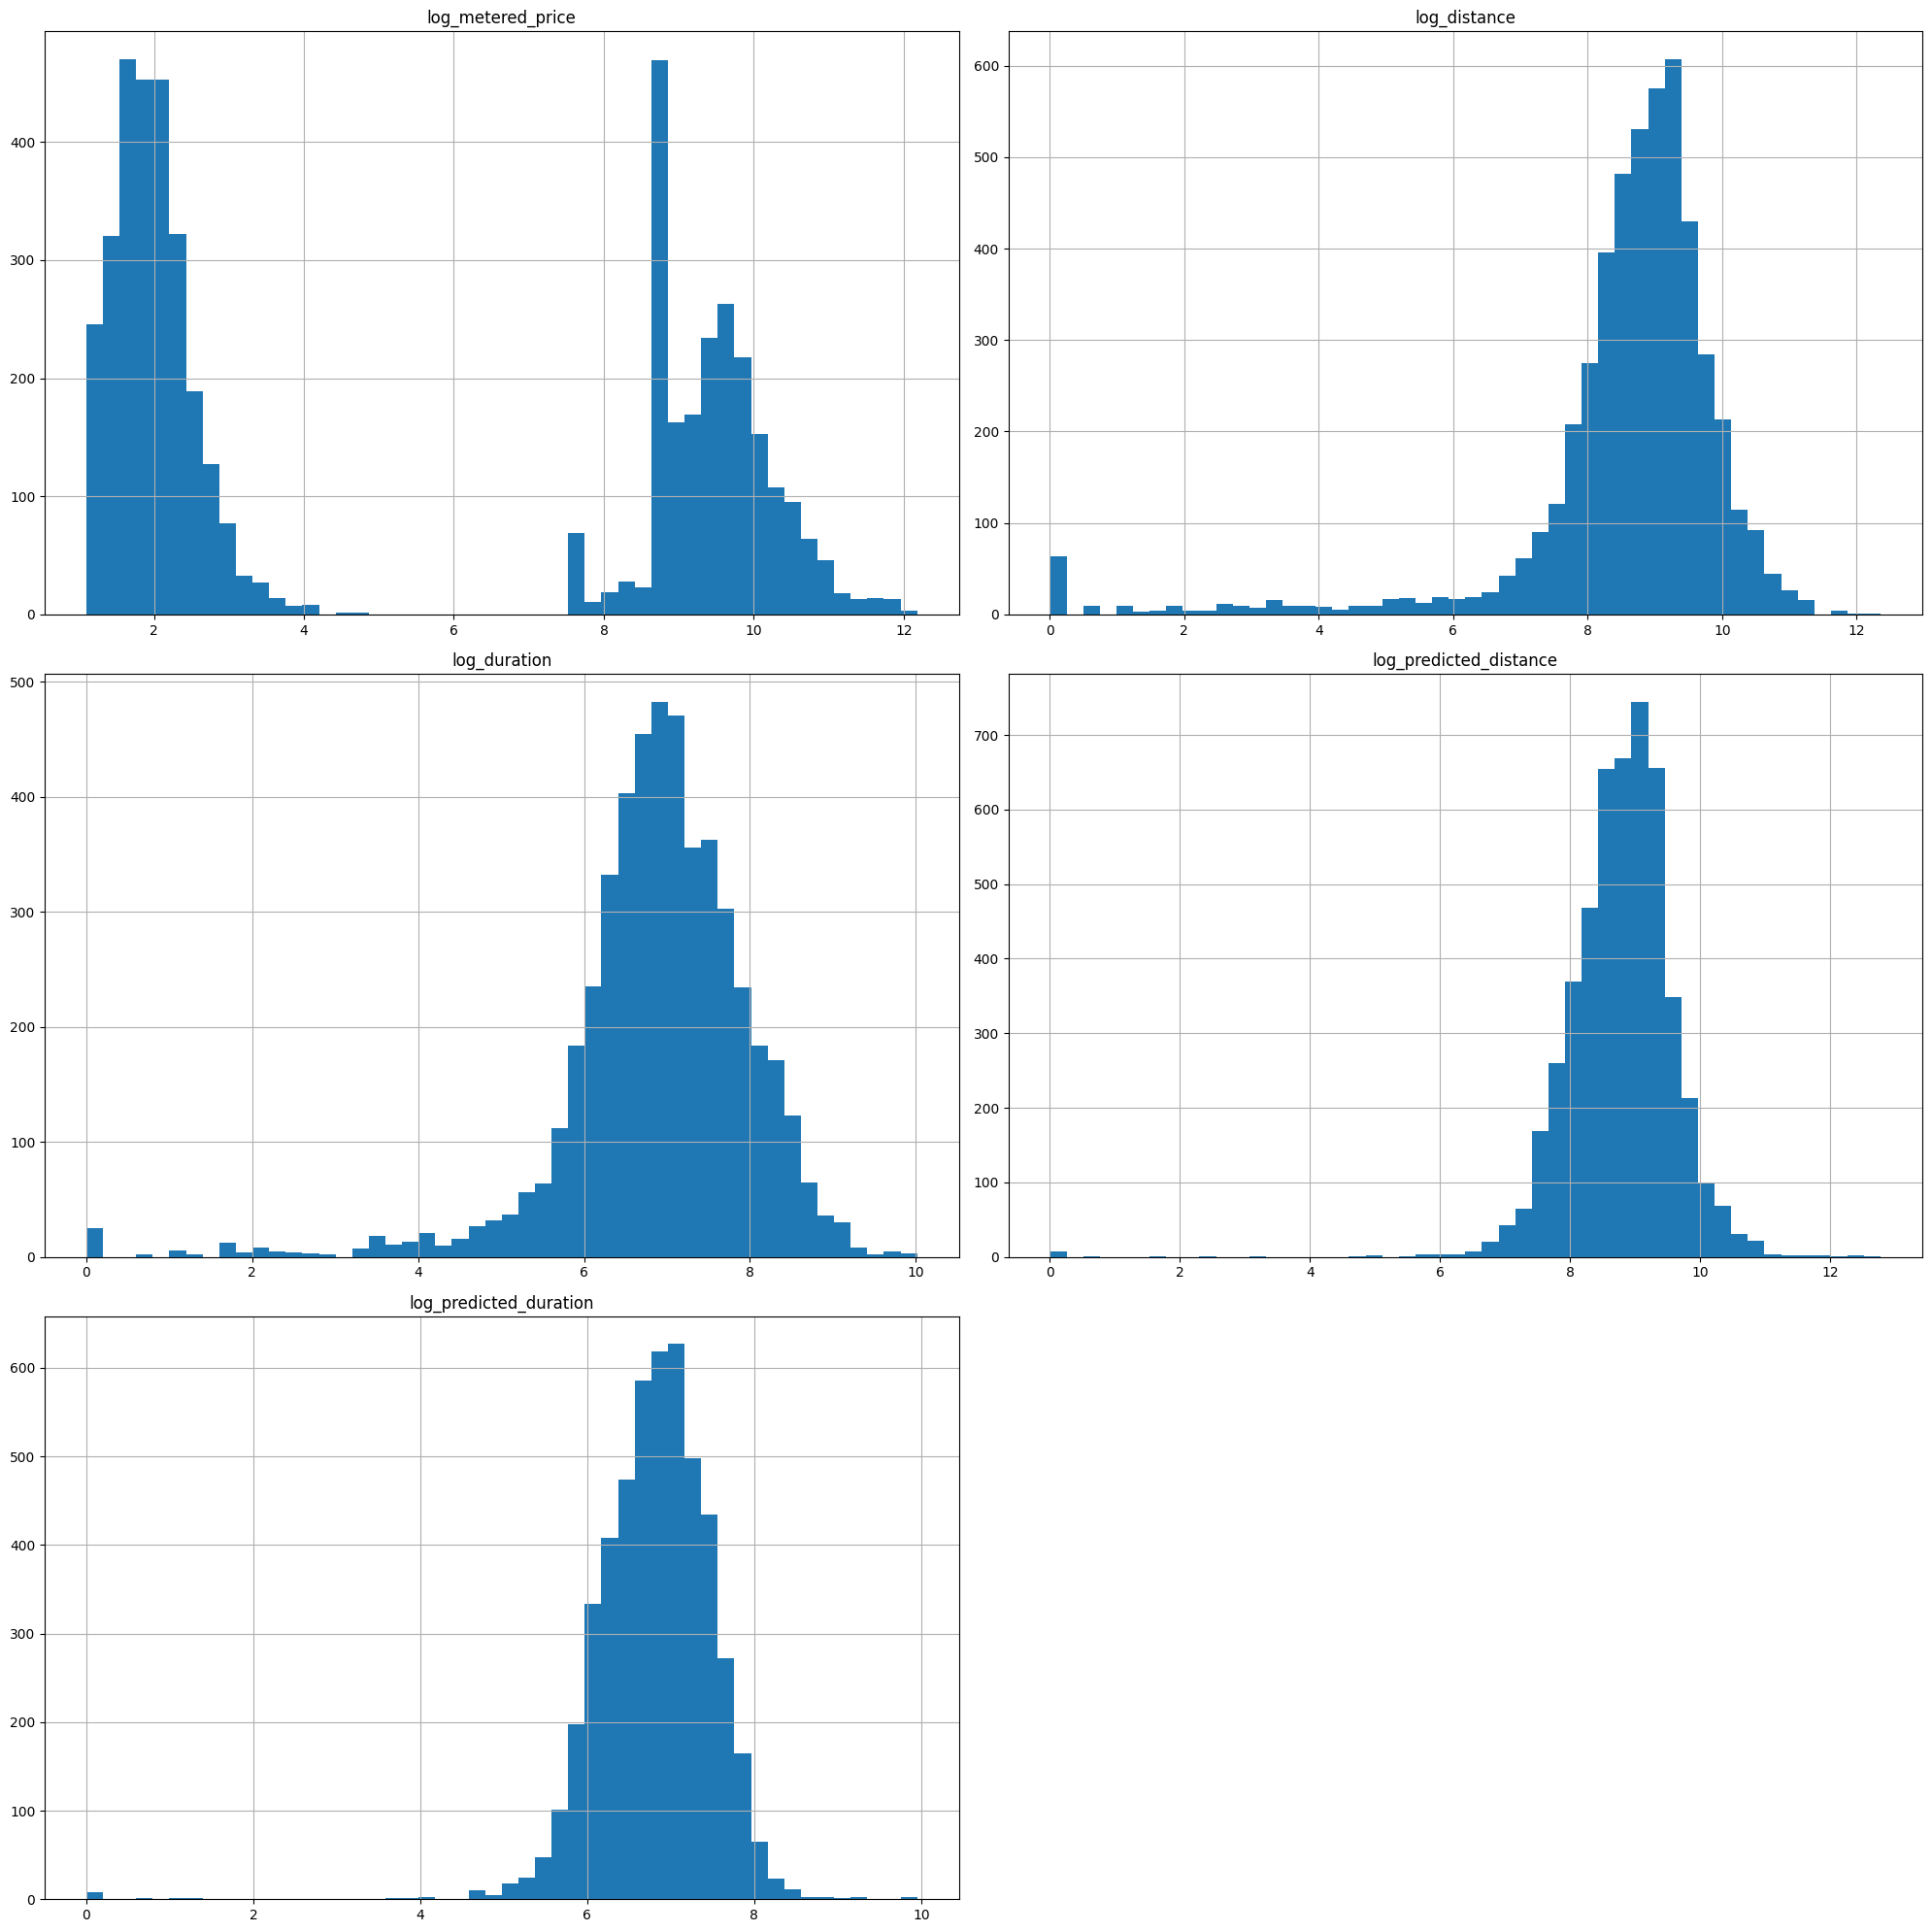

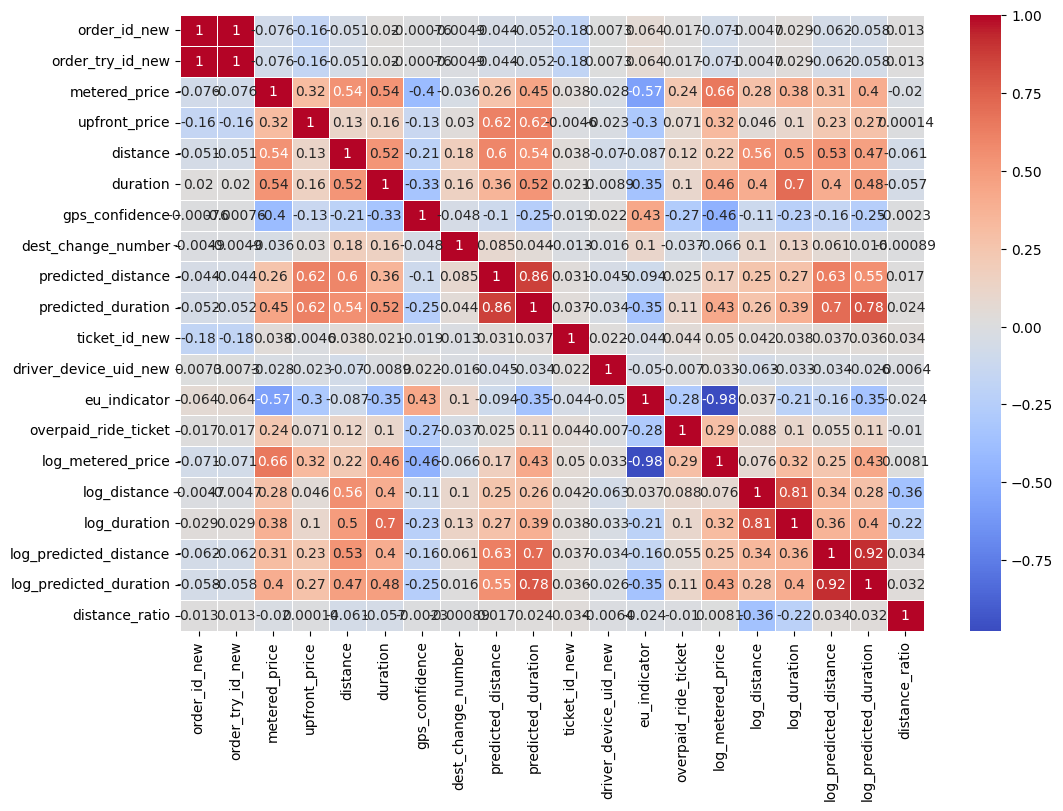

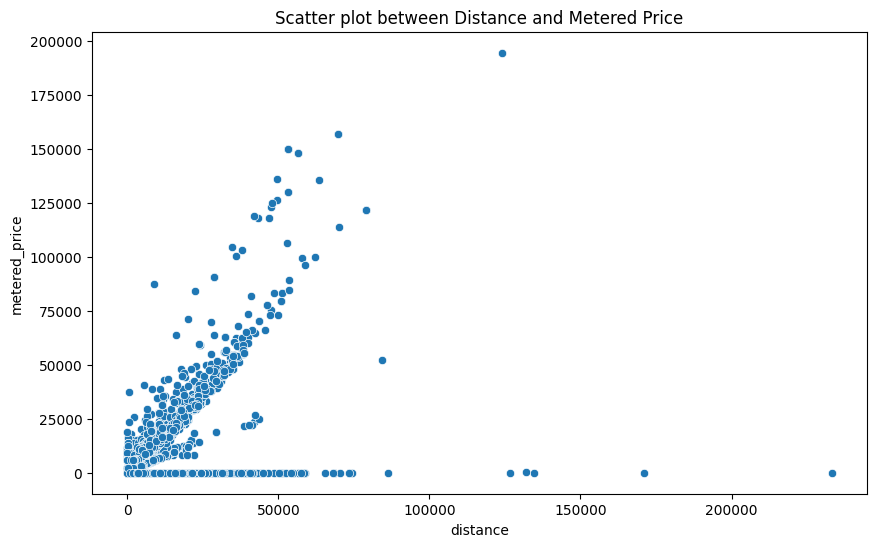

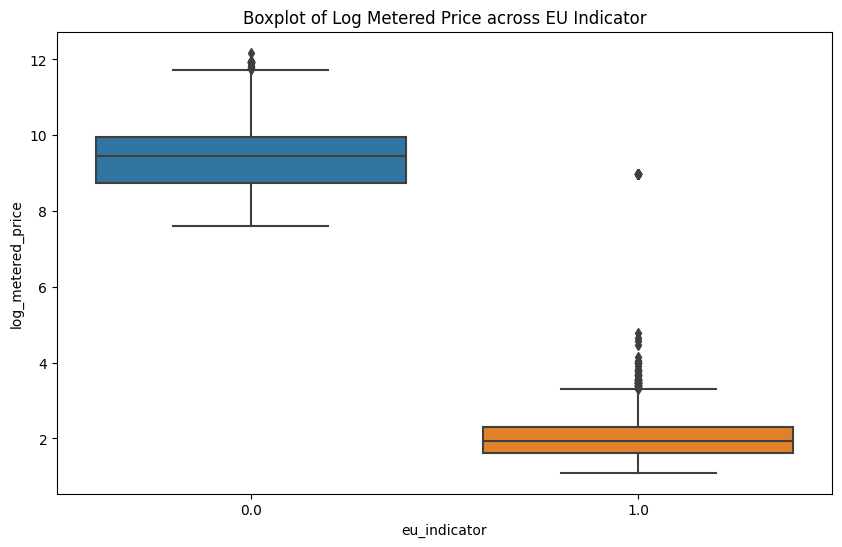

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from google.colab import drive

# Mount Google Drive and Load the Dataset
drive.mount('/content/gdrive/', force_remount=True)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/BBBOOOLLLTTT/test.csv')

# Summary statistics
print("\nSummary statistics:\n", df.describe(include='all'))

# Count of unique values and top 10 unique values for each column
for column in df.columns:
    print(f"\nColumn: {column}")
    print(f"Number of unique values: {df[column].nunique()}")
    print("Top 10 unique values:")
    print(df[column].value_counts().head(10))

# Define threshold for dropping rows/columns with missing values
threshold = 0.5 * len(df)

# Drop columns with missing values above threshold
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Drop specified columns
columns_to_drop = ['device_token', 'session_token']
df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Select only numeric columns
df_cleaned = df_cleaned.select_dtypes(include=[np.number])

# Replace infinite values with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values with mean imputation
imputer = SimpleImputer(strategy='mean')
df_cleaned_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Logarithmic transformation for right-skewed features
for column in ['metered_price', 'distance', 'duration', 'predicted_distance', 'predicted_duration']:
    df_cleaned_imputed[f'log_{column}'] = np.log1p(df_cleaned_imputed[column])

# Feature Engineering: Distance Ratio
df_cleaned_imputed['distance_ratio'] = df_cleaned_imputed['predicted_distance'] / df_cleaned_imputed['distance']

# Visualize histograms for transformed features
log_features = ['log_metered_price', 'log_distance', 'log_duration', 'log_predicted_distance', 'log_predicted_duration']
df_cleaned_imputed[log_features].hist(bins=50, figsize=(20, 20))
plt.tight_layout()
plt.show()

# Visualize correlation heatmap
corr_matrix = df_cleaned_imputed.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Scatter plot for correlated features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned_imputed, x='distance', y='metered_price')
plt.title("Scatter plot between Distance and Metered Price")
plt.show()

# Boxplot for metered price across EU indicator
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned_imputed, x='eu_indicator', y='log_metered_price')
plt.title("Boxplot of Log Metered Price across EU Indicator")
plt.show()


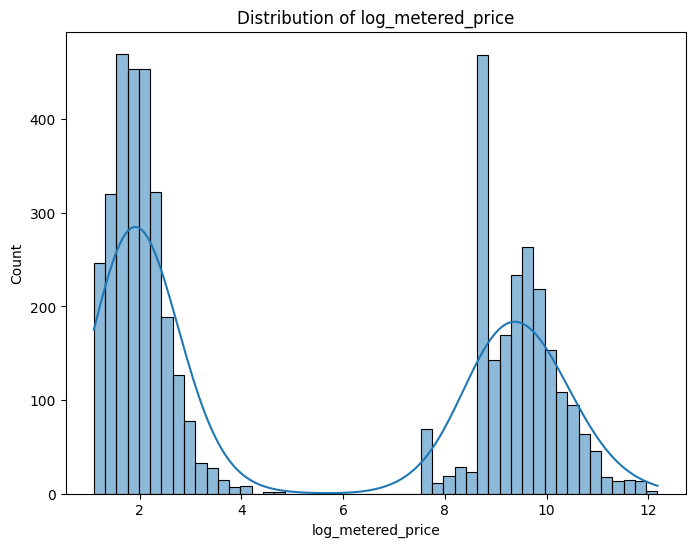

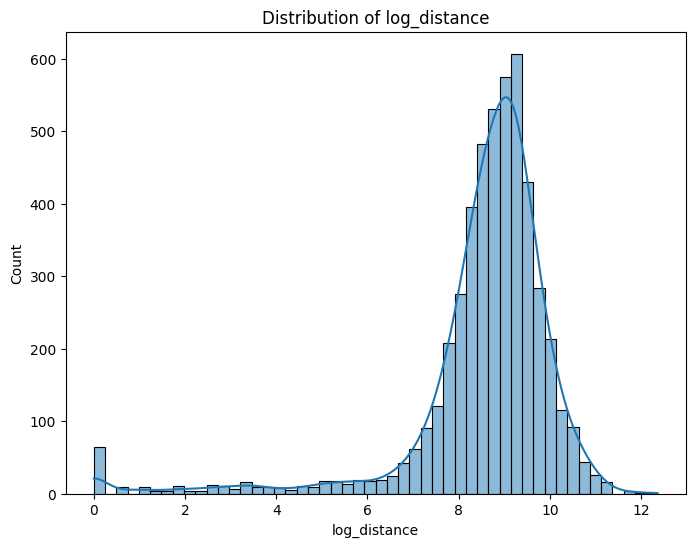

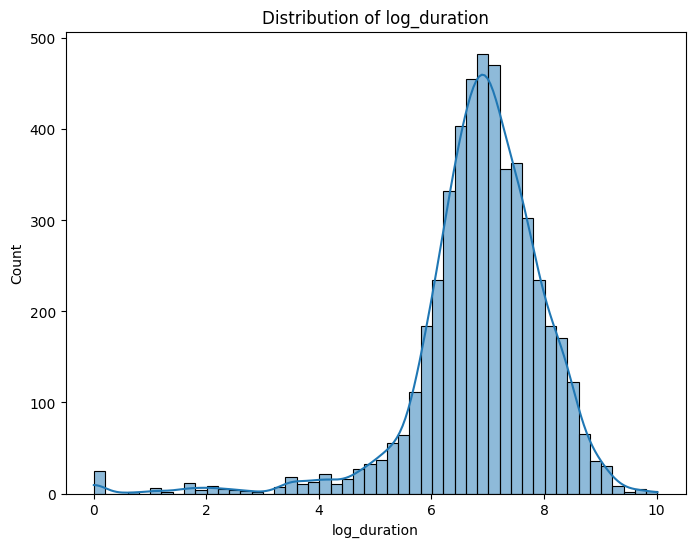

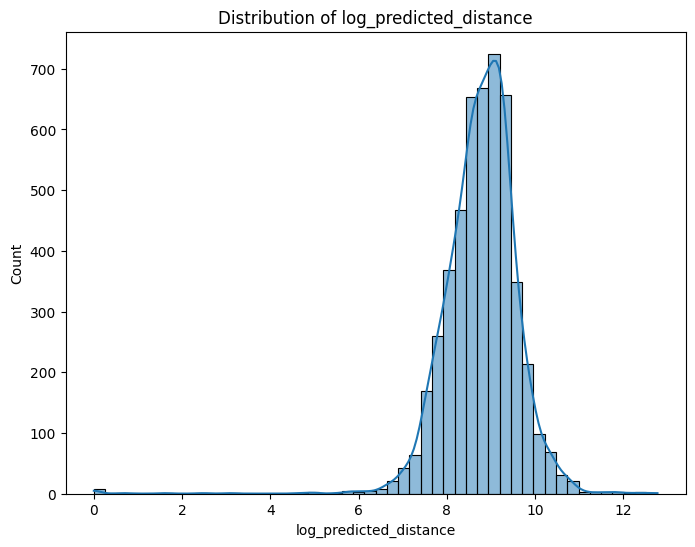

In [7]:
import numpy as np

# Create log-transformed columns
df['log_metered_price'] = np.log1p(df['metered_price'])
df['log_distance'] = np.log1p(df['distance'])
df['log_duration'] = np.log1p(df['duration'])
df['log_predicted_distance'] = np.log1p(df['predicted_distance'])

features = ['log_metered_price', 'log_distance', 'log_duration', 'log_predicted_distance']
for feature in features:
    plt.figure(figsize=(8,6))
    sns.histplot(data=df, x=feature, bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()



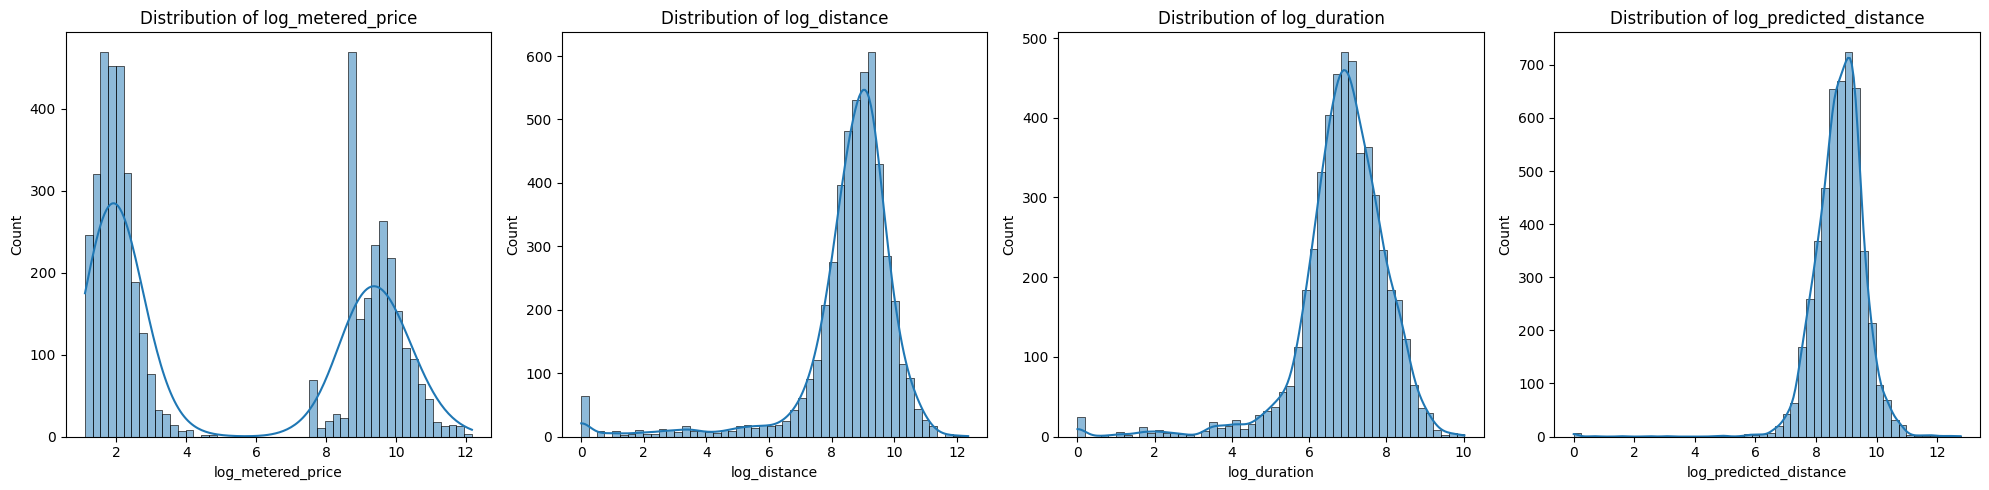

In [8]:
features = ['log_metered_price', 'log_distance', 'log_duration', 'log_predicted_distance']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 5))

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


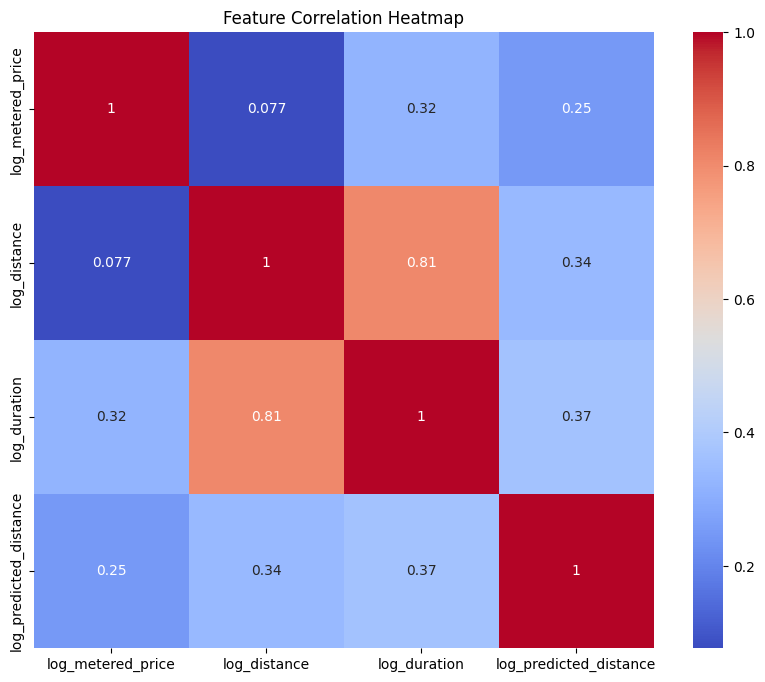

Outliers for log_metered_price:
      log_metered_price
3             11.196470
4              9.905161
6              9.940504
8              9.517935
15             9.521076
...                 ...
4928          11.964046
4929           8.012217
4935           8.699681
4939           9.081402
4942          10.283467

[2091 rows x 1 columns]
Mean error between predicted and actual distance: 0.23
Standard deviation of error: 1.60


In [9]:
# Analyze Outliers for log_metered_price
outliers_metered_price = df[df['log_metered_price'] > 8]

# Correlation Analysis
correlation_matrix = df[['log_metered_price', 'log_distance', 'log_duration', 'log_predicted_distance']].corr()

# Error Analysis
df['distance_error'] = df['log_predicted_distance'] - df['log_distance']

# Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Display outliers
print("Outliers for log_metered_price:")
print(outliers_metered_price[['log_metered_price']])

# Display mean and std of distance error
mean_error = df['distance_error'].mean()
std_error = df['distance_error'].std()

print(f"Mean error between predicted and actual distance: {mean_error:.2f}")
print(f"Standard deviation of error: {std_error:.2f}")
